# Automated Car Image Scraping, Validation, and Dataset Preparation Workflow

This notebook provides a streamlined workflow for building a high-quality car image dataset, ready for machine learning tasks. The process is fully automated and includes the following steps:

---

**1. Automated Scraping**  
Collect car images from multiple online sources with non-duplicate URLs.

- **Current Sources:**  
    - Google Images  
    - Carmudi  
    - Mobil123  

---

**2. Image Validation & Cropping**  
Checks each image for quality and consistency, cropping them as needed to standardize the dataset.

---

**3. Dataset Splitting**  
Organizes validated images into training, validation, and test sets for machine learning workflows.

---

**4. Comprehensive Reporting**  
Generates visual and tabular reports on:

- Scraping performance  
- Validation status  
- Class distribution  

---

This workflow ensures you have a clean, well-organized, and well-documented car image dataset.

In [1]:
# Install playwright for Browser scraping

!playwright install

In [2]:
# Define constants based on the configuration file

import json
import os

DATA_PROCESSING_DIRECTORY = "./data_processing"
BASE_DIRECTORY = os.path.join(DATA_PROCESSING_DIRECTORY, "scraping")
CONFIG_PATH = os.path.join(BASE_DIRECTORY, "config.json")


OUTPUT_DIRECTORY = os.path.join(DATA_PROCESSING_DIRECTORY, "data")
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

REPORTS_DIRECTORY = os.path.join(OUTPUT_DIRECTORY, "reports")
os.makedirs(REPORTS_DIRECTORY, exist_ok=True)

IMAGES_DIRECTORY = os.path.join(OUTPUT_DIRECTORY, "images")
os.makedirs(IMAGES_DIRECTORY, exist_ok=True)

MASTER_CSV_PATH = os.path.join(REPORTS_DIRECTORY, "master_scraper_results.csv")
SUMMARY_CSV_PATH = os.path.join(REPORTS_DIRECTORY, "scrape_summary_report.csv")

with open(CONFIG_PATH, "r") as config_file:
    config = json.load(config_file)

print("⚙️ Configuration loaded. Ready to run the scraper in the next cell.")

⚙️ Configuration loaded. Ready to run the scraper in the next cell.


In [3]:
# Run the scraper

from data_processing.scraping.master_scraper import MasterScraper


print("Starting the scraping and downloading process...")
scraper = MasterScraper(
    config_path=CONFIG_PATH,
    images_dir=IMAGES_DIRECTORY,
    csv_path=MASTER_CSV_PATH,
    summary_csv_path=SUMMARY_CSV_PATH,
)
await scraper.run()

print("\n✅ Scraping and downloading process finished!")

Starting the scraping and downloading process...
Launching browser for scraping...


Scraping All Sources: 100%|██████████| 360/360 [14:42<00:00,  2.45s/it]


Scraping finished successfully and reports were saved.
Scraper resources have been closed.

✅ Scraping and downloading process finished!


In [4]:
# Validate and crop images

from data_processing.scraping.dataset_validator import DatasetValidator

REJECTED_DIR = os.path.join(OUTPUT_DIRECTORY, "rejected_images")
os.makedirs(REJECTED_DIR, exist_ok=True)

print("Starting dataset validation...")
validator = DatasetValidator(
    master_csv_path=MASTER_CSV_PATH,
    rejected_dir=REJECTED_DIR,
    min_resolution=(200, 200),
)
validator.validate_and_crop_images()

print("\n✅ Validation and cropping process finished!")

Starting dataset validation...
YOLOv12 object detection model loaded.
Found 33707 downloaded images to validate and crop.


Validating & Cropping Images:   0%|          | 0/33707 [00:00<?, ?it/s]2025-06-23 00:31:53,896 - ERROR - Could not process ./data_processing/data/images/mpv/mpv_6919741656653324292.jpg: 'Conv' object has no attribute 'bn'
2025-06-23 00:31:53,896 - ERROR - Could not process ./data_processing/data/images/mpv/mpv_5003694319417688083.jpg: 'Conv' object has no attribute 'bn'
2025-06-23 00:31:53,896 - ERROR - Could not process ./data_processing/data/images/mpv/mpv_1853661484932701704.jpg: 'Conv' object has no attribute 'bn'
Validating & Cropping Images:   0%|          | 1/33707 [00:00<1:38:38,  5.69it/s]2025-06-23 00:31:53,897 - ERROR - Could not process ./data_processing/data/images/mpv/mpv_-245467956310518776.jpg: 'Conv' object has no attribute 'bn'
2025-06-23 00:31:53,897 - ERROR - Could not process ./data_processing/data/images/mpv/mpv_9219082696575611403.jpg: 'Conv' object has no attribute 'bn'


Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)


2025-06-23 00:31:53,897 - ERROR - Could not process ./data_processing/data/images/mpv/mpv_-8017219174868033520.jpg: 'Conv' object has no attribute 'bn'


Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)


2025-06-23 00:31:53,897 - ERROR - Could not process ./data_processing/data/images/mpv/mpv_4620860105427352078.jpg: 'Conv' object has no attribute 'bn'


Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
YOLOv12s summary (fused): 159 layers, 9,261,840 parameters, 0 gradients, 21.4 GFLOPs
YOLOv12s summary (fused): 159 layers, 9,261,840 parameters, 0 gradients, 21.4 GFLOPs
YOLOv12s summary (fused): 159 layers, 9,261,840 parameters, 0 gradients, 21.4 GFLOPs
YOLOv12s summary (fused): 159 layers, 9,261,840 parameters, 0 gradients, 21.4 GFLOPs
YOLOv12s summary (fused): 159 layers, 9,261,840 parameters, 0 gradients, 21.4 GFLOPs
YOLOv12s summary (fused): 159 layers, 9,261,840 parameters, 0 gradients, 21.4 GFLOPs
YOLOv12s summary (fused): 159 layers, 9,261,840 parameters, 0 gradients, 21.4 GFLOPs
YOLOv12s summary (fused): 1

Validating & Cropping Images: 100%|██████████| 33707/33707 [53:27<00:00, 10.51it/s]  


Validation complete. Report saved to ./data_processing/data/reports/master_scraper_results.csv

✅ Validation and cropping process finished!


In [5]:
# Split the dataset into training, validation, and test sets

import os

from data_processing.scraping.create_dataset_split import DatasetSplitter

print("Starting Dataset Splitting")

FINAL_DATASET_DIR = os.path.join(OUTPUT_DIRECTORY, "dataset")

splitter = DatasetSplitter(
    source_dir=IMAGES_DIRECTORY,
    output_dir=FINAL_DATASET_DIR,
)
splitter.split_and_copy()

print("\n✅ Dataset splitting process finished!")

Starting Dataset Splitting


Copying test files: 100%|██████████| 1789/1789 [00:00<00:00, 2592.10it/s]


Total images in source: 17887
--------------------
Training set: 14309 images
Validation set: 1789 images
Test set: 1789 images
Total split: 17887 images

✅ Dataset splitting process finished!



PART 1: SCRAPING PERFORMANCE REPORT (UNIQUES vs. DUPLICATES)
Unique URLs Found vs. Duplicates Skipped per Source:


,Source,unique_found,duplicates_skipped
0,OLX,12724,41
1,Google,14646,5153
2,Mobil123,3404,81
3,Carmudi,3025,55


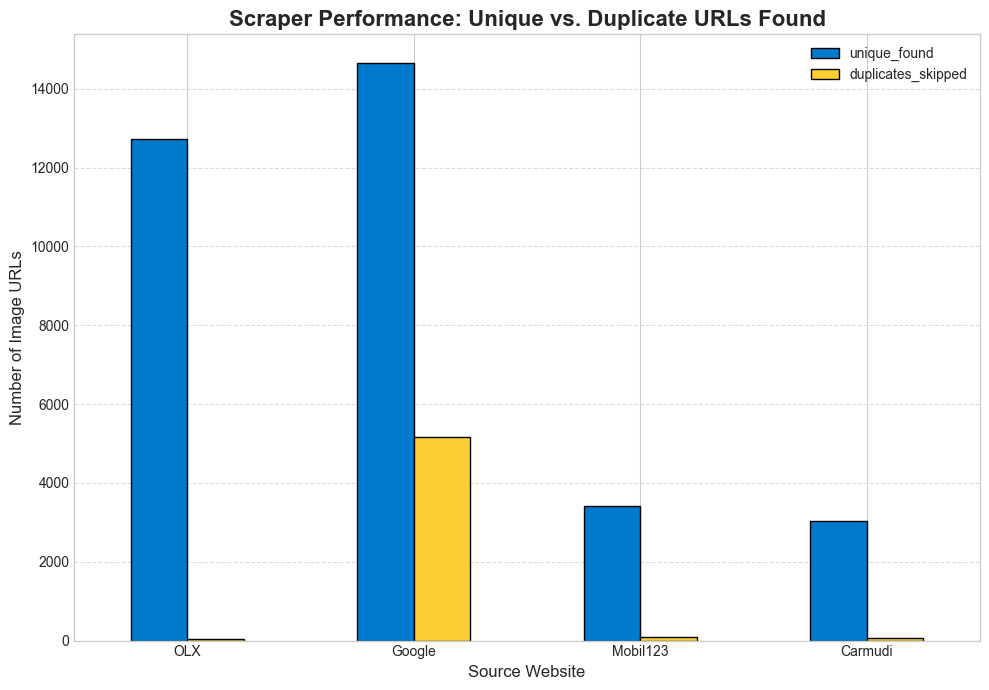


PART 2: VALIDATION & FINAL DATASET REPORT

--- 2a. Overall Validation Status ---


validation_status
valid_and_cropped            17887
rejected_low_resolution      13454
rejected_not_a_car            2359
rejected_processing_error        7
Name: count, dtype: int64

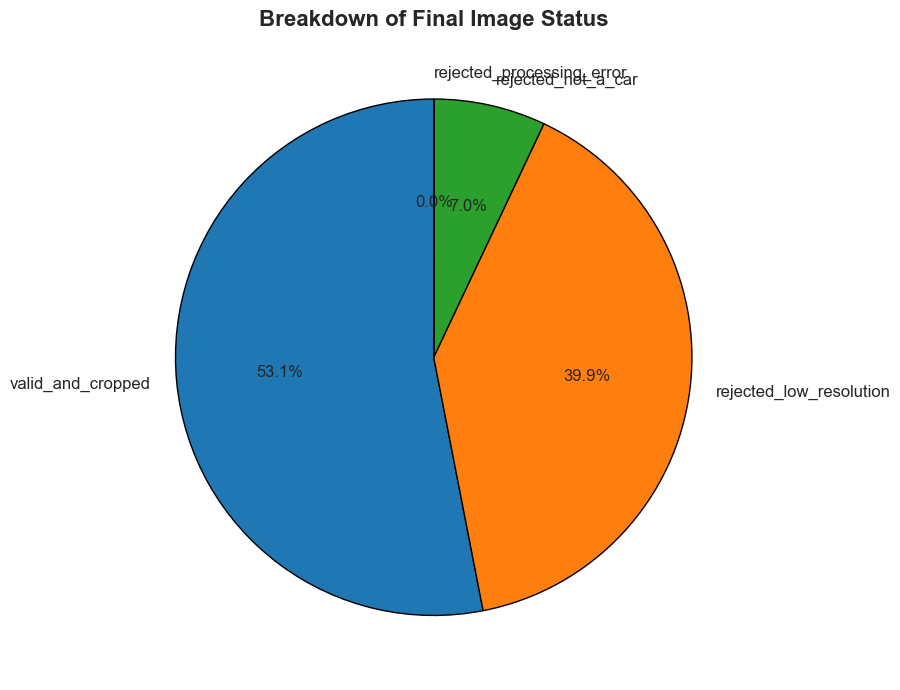


--- 2b. Final Class Distribution ---


class
suv          3427
mpv          3312
sedan        2722
city_car     2570
pickup       1870
hatchback    1806
van          1384
truck         796
Name: count, dtype: int64

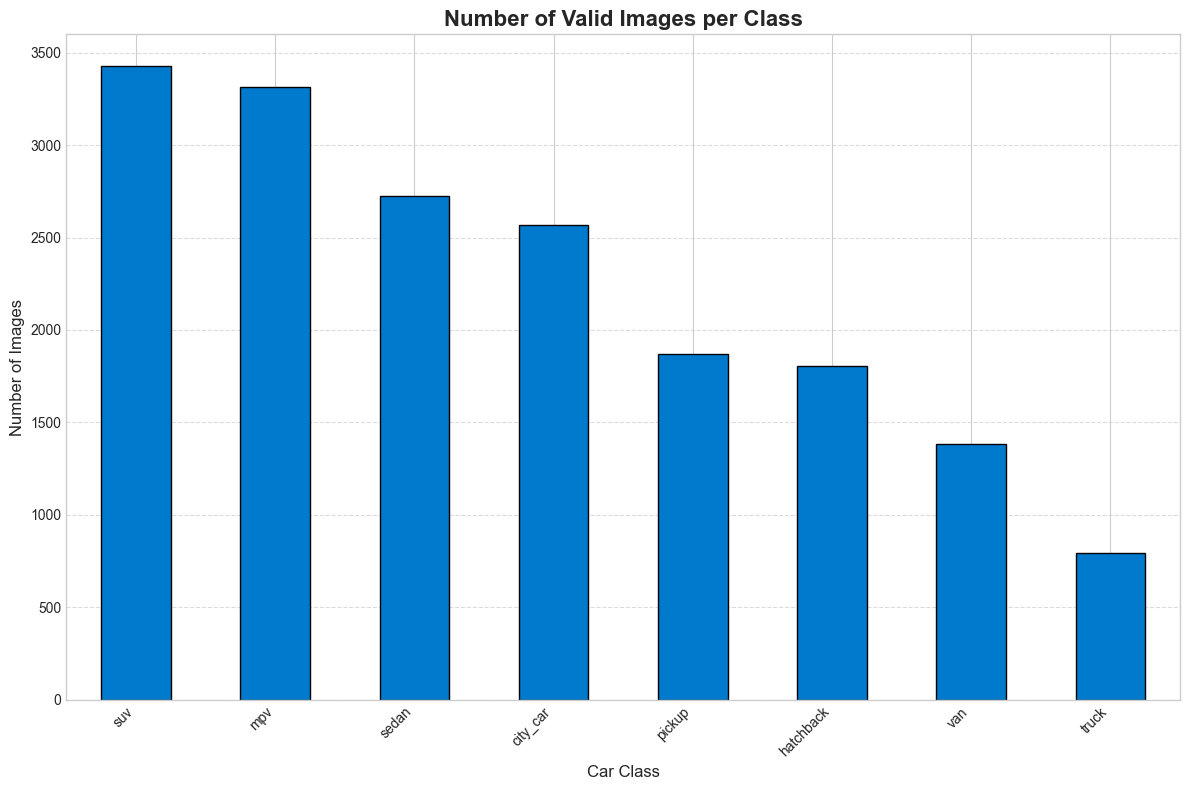

In [6]:
# Generate reports for scraping performance and validation results

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os


def load_all_data(config_file="config.json"):
    """Loads config and all necessary report CSVs."""
    summary_df, master_df = None, None
    try:

        if os.path.exists(SUMMARY_CSV_PATH):
            summary_df = pd.read_csv(SUMMARY_CSV_PATH)
        else:
            print(
                f"❌ Scrape summary file not found at {SUMMARY_CSV_PATH}. Please run Cell 2."
            )

        if os.path.exists(MASTER_CSV_PATH):
            master_df = pd.read_csv(MASTER_CSV_PATH)
        else:
            print(
                f"❌ Master data file not found at {MASTER_CSV_PATH}. Please run Cell 3."
            )

        return summary_df, master_df
    except FileNotFoundError:
        print(f"❌ {config_file} not found. Please run Cell 1 to create it.")
        return None, None, None


def plot_scraping_performance(df, reports_path):
    """Generates and displays a bar chart for unique vs. duplicate URLs."""
    print("\n" + "=" * 80)
    print("PART 1: SCRAPING PERFORMANCE REPORT (UNIQUES vs. DUPLICATES)")
    print("=" * 80)
    print("Unique URLs Found vs. Duplicates Skipped per Source:")
    display(df)

    df.plot(
        x="Source",
        y=["unique_found", "duplicates_skipped"],
        kind="bar",
        figsize=(10, 7),
        color=["#007ACC", "#FDCF33"],
        edgecolor="black",
    )
    plt.title(
        "Scraper Performance: Unique vs. Duplicate URLs Found",
        fontsize=16,
        weight="bold",
    )
    plt.ylabel("Number of Image URLs", fontsize=12)
    plt.xlabel("Source Website", fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(reports_path, "chart_scraping_performance.png"))
    plt.show()


def plot_validation_pie_chart(df, reports_path):
    """Generates a pie chart of the overall validation status."""
    print("\n--- 2a. Overall Validation Status ---")
    status_counts = df["validation_status"].value_counts()
    display(status_counts)

    plt.figure(figsize=(10, 7))
    status_counts.plot.pie(
        autopct="%1.1f%%",
        startangle=90,
        wedgeprops={"edgecolor": "black", "linewidth": 1},
        textprops={"fontsize": 12},
    )
    plt.title("Breakdown of Final Image Status", fontsize=16, weight="bold")
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig(os.path.join(reports_path, "chart_validation_status.png"))
    plt.show()


def plot_class_distribution_chart(df, reports_path):
    """Generates a bar chart showing the number of valid images per class."""
    print("\n--- 2b. Final Class Distribution ---")
    class_counts = df["class"].value_counts()
    display(class_counts)

    plt.figure(figsize=(12, 8))
    class_counts.plot(kind="bar", color="#007ACC", edgecolor="black")
    plt.title("Number of Valid Images per Class", fontsize=16, weight="bold")
    plt.ylabel("Number of Images", fontsize=12)
    plt.xlabel("Car Class", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(reports_path, "chart_class_distribution.png"))
    plt.show()


def generate_all_reports():
    """
    Main function to orchestrate the entire reporting process, including
    scraping performance and validation results.
    """
    plt.style.use("seaborn-v0_8-whitegrid")

    summary_df, master_df = load_all_data()

    if summary_df is not None:
        plot_scraping_performance(summary_df, REPORTS_DIRECTORY)

    if master_df is not None and "validation_status" in master_df.columns:
        print("\n" + "=" * 80)
        print("PART 2: VALIDATION & FINAL DATASET REPORT")
        print("=" * 80)

        valid_images_df = master_df[
            master_df["validation_status"] == "valid_and_cropped"
        ].copy()

        plot_validation_pie_chart(master_df, REPORTS_DIRECTORY)

        if not valid_images_df.empty:
            plot_class_distribution_chart(valid_images_df, REPORTS_DIRECTORY)
        else:
            print("\nNo valid images found to generate final dataset reports.")
    else:
        print("\nSkipping validation reports because data file was not found or not validated.")


generate_all_reports()